# Uncertainy quantification

BABEL's embedding space also provides a basis for measuring confidence in downstream classifications. Such confidence measures are useful for quantifying how "trustworthy" BABEL's predictions might be on new data. 

Intuitively, within the embedding space, in-distribution examples should share a subspace, and exmaples outside this subspace are likely to be out of distribution and therefore low confidence. Here, we explore this idea by building a Gaussian Process classifier that predicts in-vs-out of distribution, which we interpret informally as an estimate of BABEL's confidence. Although this measure is applied to the embedding, its estimates are valid for output RNA/ATAC modalities as well, since this embedding is a predecessor to those outputs.

In [1]:
import os, sys
import collections
import functools
import json
import importlib
import logging

import numpy as np
import pandas as pd
from scipy import stats, sparse, spatial
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessClassifier
from matplotlib import pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

import gdown
import tqdm.notebook

SRC_DIR = os.path.join(os.path.dirname(os.getcwd()), 'babel')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import utils

BIN_DIR = os.path.join(os.path.dirname(SRC_DIR), "bin")
assert os.path.isfile(os.path.join(BIN_DIR, "predict_model.py"))

import perturb

DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
assert os.path.isdir(DATA_DIR)
print(DATA_DIR)

logging.basicConfig(level=logging.INFO)

/home/wukevin/projects/babel/data


## Data setup

First, we download and ensure data is in the expected locations.

In [2]:
# PBMC ATAC data
pbmc_h5_fname = os.path.join(DATA_DIR, "10x", "atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5")
assert os.path.isfile(pbmc_h5_fname)

In [3]:
# Download BCC ATAC data
# https://drive.google.com/file/d/1dv1l-dgrWiHey-RS0SwS_ASn4gVQ_qZu/view?usp=sharing
bcc_adata_fname = gdown.cached_download(
    url="https://drive.google.com/uc?id=1dv1l-dgrWiHey-RS0SwS_ASn4gVQ_qZu",
    path=os.path.join(DATA_DIR, "bcc/GSE129785_scATAC-TME-All.h5ad"),
    md5="09cc204cabd59fdf5aa9c07fa29de961",
    quiet=False,
)

Computing MD5: /home/wukevin/projects/babel/data/bcc/GSE129785_scATAC-TME-All.h5ad
MD5 matches: /home/wukevin/projects/babel/data/bcc/GSE129785_scATAC-TME-All.h5ad


## PBMC perturbation

We take PBMC scATAC-seq data and perturb it. Both the original, unperturbed data and the perturbed data are then fed through BABEL to generate corresponding (16-dimensional) embeddings. We then use the original, unperturbed BABEL embeddings as examples of "in-distribution" data, and the perturbed BABEL embeddings as examples of "out-of-distribution" data to train a Gaussian Process classifier to distinguish between the two. 

In [4]:
# Define how we will perform perturbations
drop_method = "swap"
drop_p = 0.5
swapper = perturb.swap_adata if drop_method == "swap" else perturb.dropout_adata
swapper

<function perturb.swap_adata(adata: anndata.core.anndata.AnnData, p: float = 0.1, mode: str = 'zero_nonzero', copy: bool = True, seed: int = 6489) -> anndata.core.anndata.AnnData>

In [5]:
pbmc_atac_vanilla_adata = sc.read_10x_h5(pbmc_h5_fname, gex_only=False)
pbmc_atac_vanilla_adata

AnnData object with n_obs × n_vars = 8633 × 80234 
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
pbmc_atac_dropped_adata = swapper(pbmc_atac_vanilla_adata, p=drop_p)
pbmc_atac_dropped_adata_fname = os.path.join(DATA_DIR, "10x", "atac_v1_pbmc_10k_filtered_peak_bc_matrix_dropped.h5ad")
pbmc_atac_dropped_adata.write_h5ad(pbmc_atac_dropped_adata_fname)

INFO:root:Swapping 0.5 of values in each observation
... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [7]:
%%bash -s  "$DATA_DIR" "$pbmc_h5_fname"

python /home/wukevin/projects/babel/bin/predict_model.py --data ${2} --outdir ${1}/10x/babel_atac_to_rna_pbmc_vanilla --noplot --liftHg19toHg38 --transonly --device 0

INFO:root:Evaluating: /home/wukevin/projects/babel/data/10x/atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5
INFO:root:Model tarball at: /home/wukevin/.cache/babel_atac_rna/babel_human_v1.1.tar.gz
INFO:root:Inferred RNA input dimension: 34861
INFO:root:Inferred ATAC input dimension: [19602, 9956, 10323, 12262, 8982, 7845, 6207, 7099, 8775, 4851, 5230, 21793, 5815, 2587, 3516, 16973, 14702, 12519, 13318, 11534, 9999, 10009] (sum=223897)
INFO:root:Inferred model with basename cv_logsplit_01_model_only be normal (non-naive)
INFO:root:ChromDecoder with 1 output activations
INFO:root:Loaded model with hidden size 16
INFO:root:Building RNA dataset with parameters: {'reader': functools.partial(<function sc_read_multi_files at 0x7fd275298710>, reader=<function load_rna_files_for_eval.<locals>.<lambda> at 0x7fd205bea8c0>), 'transpose': False, 'gtf_file': '/home/wukevin/projects/babel/data/Homo_sapiens.GRCh38.100.gtf.gz', 'autosomes_only': True, 'sort_by_pos': True, 'split_by_chrom': True, 'concat_ou

In [8]:
%%bash -s  "$DATA_DIR" "$pbmc_atac_dropped_adata_fname"

python /home/wukevin/projects/babel/bin/predict_model.py --data ${2} --outdir ${1}/10x/babel_atac_to_rna_pbmc_dropped --noplot --liftHg19toHg38 --transonly --device 0

INFO:root:Evaluating: /home/wukevin/projects/babel/data/10x/atac_v1_pbmc_10k_filtered_peak_bc_matrix_dropped.h5ad
INFO:root:Model tarball at: /home/wukevin/.cache/babel_atac_rna/babel_human_v1.1.tar.gz
INFO:root:Inferred RNA input dimension: 34861
INFO:root:Inferred ATAC input dimension: [19602, 9956, 10323, 12262, 8982, 7845, 6207, 7099, 8775, 4851, 5230, 21793, 5815, 2587, 3516, 16973, 14702, 12519, 13318, 11534, 9999, 10009] (sum=223897)
INFO:root:Inferred model with basename cv_logsplit_01_model_only be normal (non-naive)
INFO:root:ChromDecoder with 1 output activations
INFO:root:Loaded model with hidden size 16
INFO:root:Building RNA dataset with parameters: {'reader': functools.partial(<function sc_read_multi_files at 0x7fef84e17710>, reader=<function load_rna_files_for_eval.<locals>.<lambda> at 0x7fef0dd068c0>), 'transpose': False, 'gtf_file': '/home/wukevin/projects/babel/data/Homo_sapiens.GRCh38.100.gtf.gz', 'autosomes_only': True, 'sort_by_pos': True, 'split_by_chrom': True, 

In [15]:
pbmc_vanilla_embed = ad.read_h5ad(os.path.join(
    DATA_DIR,
    "10x/babel_atac_to_rna_pbmc_vanilla/atac_encoded_adata.h5ad",
))
pbmc_vanilla_embed

AnnData object with n_obs × n_vars = 8633 × 16 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [16]:
pbmc_dropped_embed = ad.read_h5ad(os.path.join(
    DATA_DIR,
    "10x/babel_atac_to_rna_pbmc_dropped/atac_encoded_adata.h5ad",
))
pbmc_dropped_embed

AnnData object with n_obs × n_vars = 8633 × 16 
    obs: 'source_file', 'n_counts', 'log1p_counts', 'n_genes', 'size_factors'

In [17]:
pbmc_gp = GaussianProcessClassifier(random_state=1234)
# label of 1 = in distribution, 0 = out of distribution
pbmc_gp.fit(
    np.vstack([pbmc_vanilla_embed.X, pbmc_dropped_embed.X]),
    [1] * pbmc_vanilla_embed.n_obs + [0] * pbmc_dropped_embed.n_obs,
)
pbmc_gp

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=1234, warm_start=False)

## BCC data

We turn to the basal cell carcinoma (BCC) dataset (Yost et al., https://www.ncbi.nlm.nih.gov/labs/pmc/articles/PMC7299161/) discussed in our manuscript. 

We know that, biologically, the BCC dataset contains celltypes (particularly, endothelial skin cells and tumor cells) that are out-of-distribution with respect to BABEL's training data; therefore, we expect that the GP trained above will produce low prediction scores (interpreted as low confidence) for these celltypes. We verify this below.

In [13]:
%%bash -s  "$DATA_DIR" "$bcc_adata_fname"

python /home/wukevin/projects/babel/bin/predict_model.py --data ${2} --outdir ${1}/bcc/babel_atac_to_rna_bcc --noplot --liftHg19toHg38 --transonly --device 0

INFO:root:Evaluating: /home/wukevin/projects/babel/data/bcc/GSE129785_scATAC-TME-All.h5ad
INFO:root:Model tarball at: /home/wukevin/.cache/babel_atac_rna/babel_human_v1.1.tar.gz
INFO:root:Inferred RNA input dimension: 34861
INFO:root:Inferred ATAC input dimension: [19602, 9956, 10323, 12262, 8982, 7845, 6207, 7099, 8775, 4851, 5230, 21793, 5815, 2587, 3516, 16973, 14702, 12519, 13318, 11534, 9999, 10009] (sum=223897)
INFO:root:Inferred model with basename cv_logsplit_01_model_only be normal (non-naive)
INFO:root:ChromDecoder with 1 output activations
INFO:root:Loaded model with hidden size 16
INFO:root:Building RNA dataset with parameters: {'reader': functools.partial(<function sc_read_multi_files at 0x7f157d883680>, reader=<function load_rna_files_for_eval.<locals>.<lambda> at 0x7f15075c1830>), 'transpose': False, 'gtf_file': '/home/wukevin/projects/babel/data/Homo_sapiens.GRCh38.100.gtf.gz', 'autosomes_only': True, 'sort_by_pos': True, 'split_by_chrom': True, 'concat_outputs': True, 

In [18]:
# Run the GP on BCC's embedding
bcc_vanilla_embed = ad.read_h5ad(os.path.join(
    DATA_DIR,
    "bcc/babel_atac_to_rna_bcc/atac_encoded_adata.h5ad",
))

bcc_gp_preds = pbmc_gp.predict_proba(bcc_vanilla_embed.X)
bcc_gp_preds.shape

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


(37818, 2)

In [19]:
bcc_vanilla_embed.obs['gp_pbmc_pred'] = bcc_gp_preds[:, 1]
bcc_vanilla_embed.obs.head()

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,source_file,n_counts,log1p_counts,n_genes,size_factors,gp_pbmc_pred
index,,,,,,,,,,,,,,,
AAACGAAAGAACGACC-1,10.567199,-4.781785,Cluster20,SU009_Tumor_Immune_Pre,62437,0.581338,AAACGAAAGAACGACC-1,SU009_Tumor_Immune_Pre_3,SU009_Tumor_Immune_Pre#AAACGAAAGAACGACC-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,5774.0,8.661294,5774,1.0,0.027143
AAACGAAAGAATACTG-1,1.443223,13.324852,Cluster14,SU001_Immune_Post2,7471,0.378932,AAACGAAAGAATACTG-1,SU001_Immune_Post2_860,SU001_Immune_Post2#AAACGAAAGAATACTG-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1222.0,7.109062,1222,1.0,0.708951
AAACGAAAGACACGGT-1,-1.004199,-7.261578,Cluster4,SU009_Tcell_Post,6832,0.712310,AAACGAAAGACACGGT-1,SU009_Tcell_Post_3423,SU009_Tcell_Post#AAACGAAAGACACGGT-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1112.0,7.014814,1112,1.0,0.701958
AAACGAAAGACCCTAT-1,-5.697628,13.187097,Cluster12,SU001_Total_Post2,7808,0.488217,AAACGAAAGACCCTAT-1,SU001_Total_Post2_795,SU001_Total_Post2#AAACGAAAGACCCTAT-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1063.0,6.969790,1063,1.0,0.917634
AAACGAAAGAGGTACC-1,-5.956334,-3.010488,Cluster8,SU009_Tcell_Pre,9788,0.737229,AAACGAAAGAGGTACC-1,SU009_Tcell_Pre_3839,SU009_Tcell_Pre#AAACGAAAGAGGTACC-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1811.0,7.502186,1811,1.0,0.960398


In [21]:
bcc_vanilla_embed.obs['ClustersNamed'] = [bcc_cluster_to_name[n] for n in bcc_vanilla_embed.obs['Clusters']]
bcc_vanilla_embed.obs.head()

,UMAP1,UMAP2,Clusters,Group,depth,FRIP,Barcodes,Internal_Name,Group_Barcode,source_file,n_counts,log1p_counts,n_genes,size_factors,gp_pbmc_pred,ClustersNamed
index,,,,,,,,,,,,,,,,
AAACGAAAGAACGACC-1,10.567199,-4.781785,Cluster20,SU009_Tumor_Immune_Pre,62437,0.581338,AAACGAAAGAACGACC-1,SU009_Tumor_Immune_Pre_3,SU009_Tumor_Immune_Pre#AAACGAAAGAACGACC-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,5774.0,8.661294,5774,1.0,0.027143,Tumor 4
AAACGAAAGAATACTG-1,1.443223,13.324852,Cluster14,SU001_Immune_Post2,7471,0.378932,AAACGAAAGAATACTG-1,SU001_Immune_Post2_860,SU001_Immune_Post2#AAACGAAAGAATACTG-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1222.0,7.109062,1222,1.0,0.708951,Myeloid
AAACGAAAGACACGGT-1,-1.004199,-7.261578,Cluster4,SU009_Tcell_Post,6832,0.712310,AAACGAAAGACACGGT-1,SU009_Tcell_Post_3423,SU009_Tcell_Post#AAACGAAAGACACGGT-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1112.0,7.014814,1112,1.0,0.701958,Regulatory CD4+ T cells
AAACGAAAGACCCTAT-1,-5.697628,13.187097,Cluster12,SU001_Total_Post2,7808,0.488217,AAACGAAAGACCCTAT-1,SU001_Total_Post2_795,SU001_Total_Post2#AAACGAAAGACCCTAT-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1063.0,6.969790,1063,1.0,0.917634,B
AAACGAAAGAGGTACC-1,-5.956334,-3.010488,Cluster8,SU009_Tcell_Pre,9788,0.737229,AAACGAAAGAGGTACC-1,SU009_Tcell_Pre_3839,SU009_Tcell_Pre#AAACGAAAGAGGTACC-1,/home/wukevin/projects/babel/data/bcc/GSE12978...,1811.0,7.502186,1811,1.0,0.960398,CD8 TEx


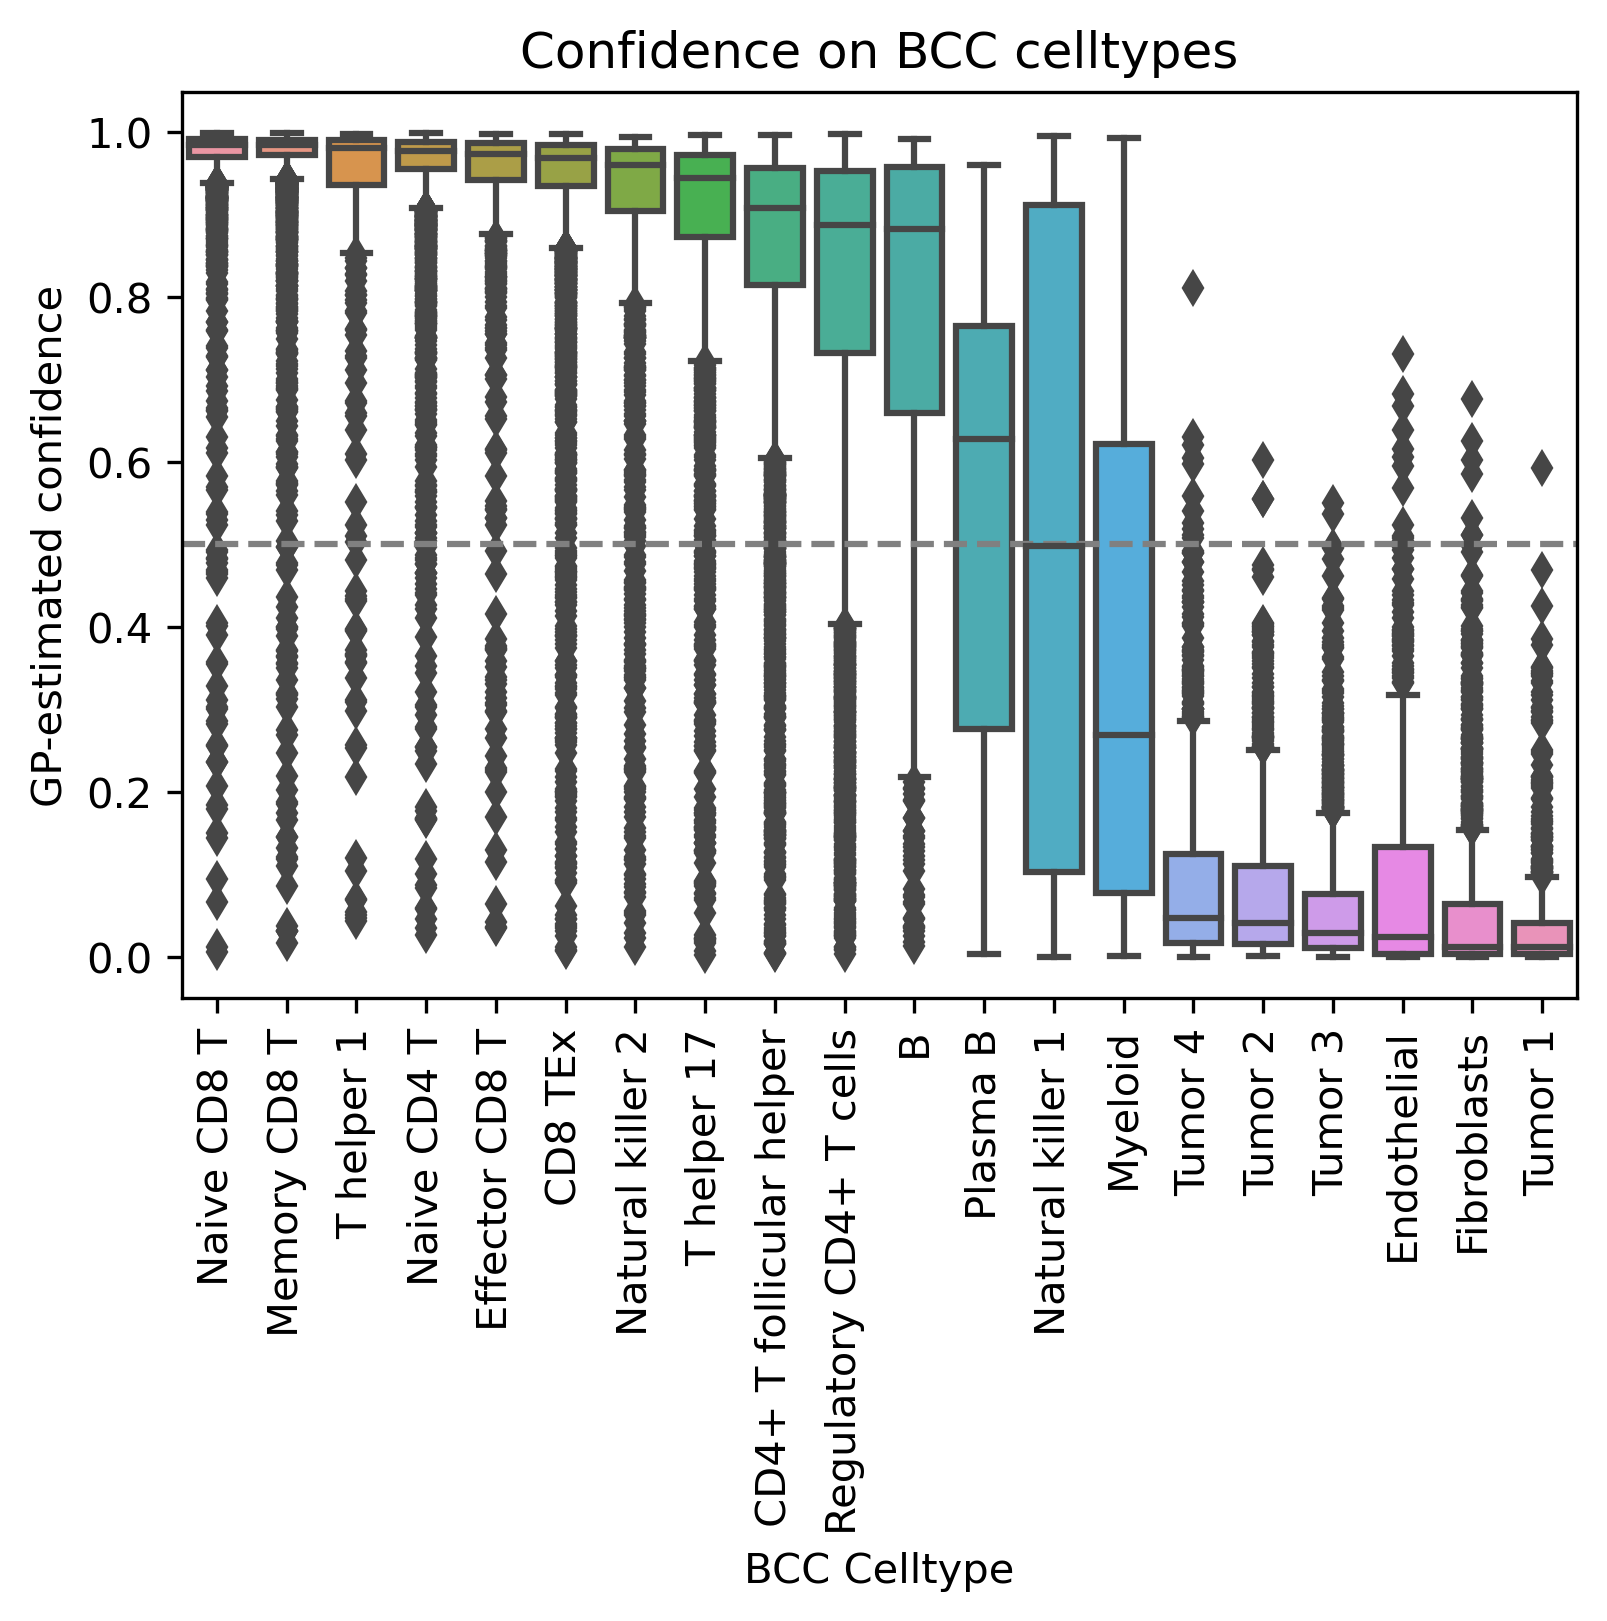

In [24]:
with open(os.path.join(DATA_DIR, "bcc/bcc_cluster_to_celltype.json")) as source:
    bcc_cluster_to_name = {f"Cluster{i+1}": cellname for i, cellname in enumerate(json.load(source))}

fig, ax = plt.subplots(dpi=300)
gp_pbmc_ordered_celltypes = bcc_vanilla_embed.obs.groupby("ClustersNamed").agg('median').sort_values('gp_pbmc_pred').index[::-1]
sns.boxplot(
    x="ClustersNamed", y="gp_pbmc_pred", data=bcc_vanilla_embed.obs, 
    order=gp_pbmc_ordered_celltypes, ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(
    title='Confidence on BCC celltypes',
    xlabel="BCC Celltype",
    ylabel="GP-estimated confidence"
)
ax.axhline(0.5, color='grey', linestyle='--')
fig.show()

In the above plot, the x-axis corresponds to the cell types present in the BCC dataset. Each box-plot shows, for each celltype, the distribution of predicted likelihood of being "in-distribution" and therefore "confident." We see that the four tumor celltypes have the lowest predicted confidence, as do endothelial cells and myeloid cells. These are consistent with what we'd expect biologically. We additionally see that B cells are relatively low-confidence; this may suggest that B cells in this BCC tissue sample are forming larger complexes (Kinker et al., https://www.frontiersin.org/articles/10.3389/fcell.2021.678127/full), thus adopting cell signatures unlike those seen in training B-cell examples.

Overall, this plot shows that training a Gaussian Process classifier on BABEL's embedding can provide a good estimate of uncertainty when attempting to generalize BABEL to new data.